# Challenge IMA 205 - Segmentation Part


Student : BAHOUS YOUNESS

In [42]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping



In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import the data

In [44]:
# Load the data nii files
dataPath = '/content/drive/MyDrive/datan/'
trainpath = os.path.join(dataPath , 'train')
imgTrainPath = os.path.join(trainpath , 'train_images')
segTrainPath = os.path.join(trainpath , 'train_seg')

valpath = os.path.join(dataPath , 'val')
imgvalPath = os.path.join(valpath , 'val_image')
segvalPath = os.path.join(valpath , 'val_segs')

testpath = os.path.join(dataPath , 'test')
imgTestPath = os.path.join(testpath , 'test_images')
segTestPath = os.path.join(testpath , 'test_seg')

# Defining constants

SEED = 666
BATCH_SIZE_TRAIN = 30
BATCH_SIZE_TEST = 30
BATCH_SIZE_VAL = 30
IMAGE_HEIGHT = 256
IMAGE_LENGTH = 256

EPOCHS = 10

In [45]:
def segmentation_generator( impath , segpath , BATCHSIZE ) :
    data_gen_args = dict( rotation_range = 0.2 ,
                          rescale = 1./255 )
    
    image_datagen = ImageDataGenerator( **data_gen_args )
    mask_datagen = ImageDataGenerator( **data_gen_args )
    image_generator = image_datagen.flow_from_directory(
        impath , target_size=(IMAGE_HEIGHT , IMAGE_LENGTH) , class_mode=None , seed=SEED , batch_size=BATCHSIZE , color_mode='grayscale' )
    mask_generator = mask_datagen.flow_from_directory( segpath , target_size=(IMAGE_HEIGHT , IMAGE_LENGTH) , class_mode=None , seed=SEED , batch_size=BATCHSIZE , color_mode='grayscale' )
    return zip( image_generator , mask_generator )

In [46]:
trainGenerator = segmentation_generator( imgTrainPath , segTrainPath , BATCH_SIZE_TRAIN )
valGenerator = segmentation_generator( imgvalPath , segvalPath , BATCH_SIZE_VAL )

Found 1788 images belonging to 1 classes.
Found 1788 images belonging to 1 classes.
Found 114 images belonging to 1 classes.
Found 114 images belonging to 1 classes.


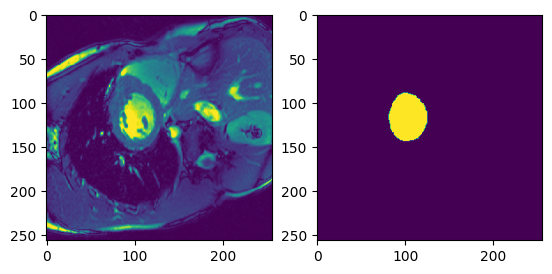

In [9]:
def show_data( generator , num = 1 ) :
    for i in range( num ) :
        image , mask = next( generator )
        fig , ax = plt.subplots( 1 , 2 )
        ax[0].imshow( image[0] )
        ax[1].imshow( mask[0] )
        plt.show()

show_data(trainGenerator)  

In [13]:
def unet(n_levels , initial_features =32 , n_blocks=2 , kernel_size=3 , pooling_size = 2 , in_channels =1 , out_channels =1 ):
    inputs = keras.layers.Input((IMAGE_HEIGHT , IMAGE_LENGTH , in_channels))
    x = inputs
    convpars = dict( activation = 'relu' , padding = 'same' , kernel_size = kernel_size )

    # Encoding path
    skips = []
    for level in range( n_levels ) :
        for _ in range( n_blocks ) :
            x = keras.layers.Conv2D( initial_features * 2 ** level , **convpars )( x )
            x = keras.layers.BatchNormalization()( x )
        if level < n_levels - 1 :
            skips.append( x )
            x = keras.layers.MaxPool2D( pooling_size )( x )
        

    # Decoding path
    for level in reversed( range( n_levels - 1 ) ) :
        x = keras.layers.Conv2DTranspose( initial_features * 2 ** level , strides = pooling_size , **convpars )( x )
        x = keras.layers.BatchNormalization()( x )
        x = keras.layers.Concatenate()([x , skips.pop()])
        for _ in range( n_blocks ) :
            x = keras.layers.Conv2D( initial_features * 2 ** level , **convpars )( x )
            x = keras.layers.BatchNormalization()( x )
    
    # Classification layer
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D( out_channels , kernel_size = 1 , activation = activation , padding = 'same' )( x )
    return keras.Model( inputs = inputs , outputs = x , name = 'UNET' )



In [51]:
model = unet(4)
model.compile( optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['binary_accuracy'] )

model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 256, 256, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 256, 256, 32  128        ['conv2d_45[0][0]']              
 ormalization)                  )                                                              

In [52]:
callback = EarlyStopping( monitor = 'loss' , patience = 3 , restore_best_weights = True )

history = model.fit( trainGenerator , validation_data= valGenerator, validation_steps= BATCH_SIZE_VAL , steps_per_epoch = 1788//30 , epochs = 40 , callbacks = [callback]) 

Epoch 1/100
59/59 [==============================] - 836s 14s/step - loss: 0.6038 - binary_accuracy: 0.8382 - val_loss: 0.5113 - val_binary_accuracy: 0.9884
Epoch 2/100
59/59 [==============================] - 55s 945ms/step - loss: 0.3304 - binary_accuracy: 0.9897 - val_loss: 0.1302 - val_binary_accuracy: 0.9883
Epoch 3/100
59/59 [==============================] - 48s 813ms/step - loss: 0.1548 - binary_accuracy: 0.9950 - val_loss: 0.0858 - val_binary_accuracy: 0.9884
Epoch 4/100
59/59 [==============================] - 55s 944ms/step - loss: 0.0841 - binary_accuracy: 0.9957 - val_loss: 0.0662 - val_binary_accuracy: 0.9887
Epoch 5/100
59/59 [==============================] - 55s 946ms/step - loss: 0.0477 - binary_accuracy: 0.9966 - val_loss: 0.0633 - val_binary_accuracy: 0.9884
Epoch 6/100
59/59 [==============================] - 56s 952ms/step - loss: 0.0327 - binary_accuracy: 0.9965 - val_loss: 0.0595 - val_binary_accuracy: 0.9884
Epoch 7/100
59/59 [==============================] - 

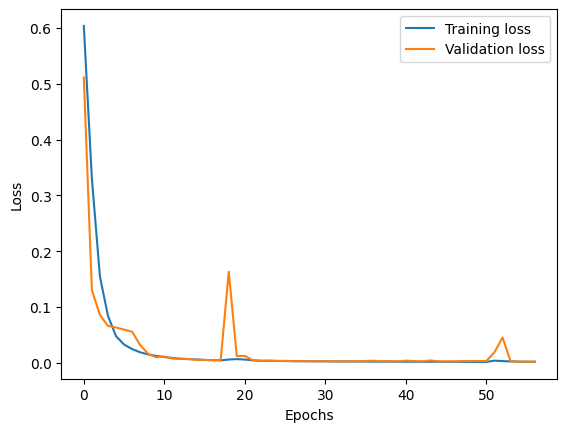

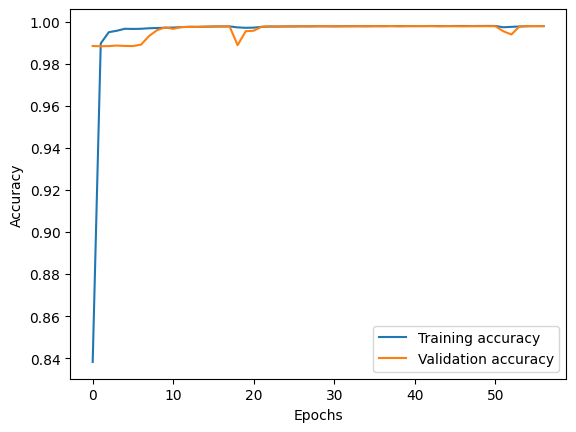

In [53]:
# Plot the training and validation loss
plt.plot( history.history['loss'] , label = 'Training loss' )
plt.plot( history.history['val_loss'] , label = 'Validation loss' )
plt.xlabel( 'Epochs' )
plt.ylabel( 'Loss' )
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot( history.history['binary_accuracy'] , label = 'Training accuracy' )
plt.plot( history.history['val_binary_accuracy'] , label = 'Validation accuracy' )
plt.xlabel( 'Epochs' )
plt.ylabel( 'Accuracy' )
plt.legend()
plt.show()

1/1 [==============================] - 0s 357ms/step


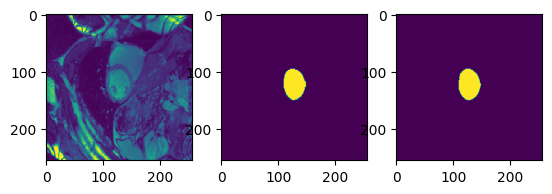

1/1 [==============================] - 0s 31ms/step


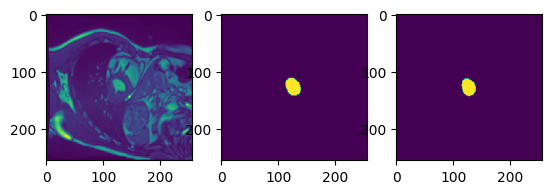

1/1 [==============================] - 0s 25ms/step


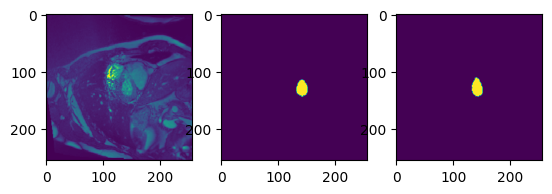

1/1 [==============================] - 0s 37ms/step


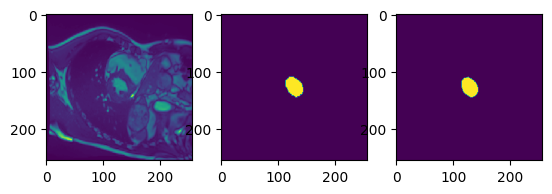

1/1 [==============================] - 0s 39ms/step


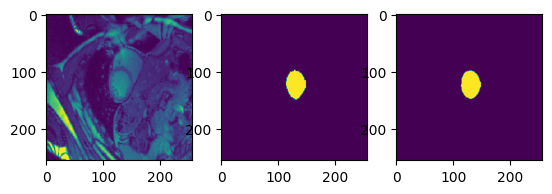

In [54]:
def show_predictions( generator , num = 1 ) :
    for i in range( num ) :
        image , mask = next( generator )
        pred_mask = model.predict( image )
        #" tresholding the mask "
        pred_mask = (pred_mask > 0.5)
        # Mask of 0 , 
        fig , ax = plt.subplots( 1 , 3 )
        ax[0].imshow( image[0] )
        ax[1].imshow( mask[0] )
        ax[2].imshow( pred_mask[0] )
        plt.show()
show_predictions( valGenerator , 5 )

In [55]:
model.save('unet30eponn.h5')